In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, InputLayer
from matplotlib import pyplot as plt

import tensorflow as tf

data_path = '/Users/kierski/Documents/ml_bmme_890/bmme_480_kierski/will_project/bmme_480_Stanford/Class Presentation/heart.csv'

In [2]:
df = pd.read_csv(data_path)
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [3]:
# Preprocessing -- One-hot encoding categorical variables, normalizing numeric vars, imputing missing data if present
# Variables to OHE: cp, restecg, slope, thal
# All others are numeric
ohe_col = ['cp','restecg','slope','thal']
cols = list(df.drop(columns=['target']).columns)
num_col = [x for x in cols if x not in ohe_col]


pipe_onehot = make_pipeline(SimpleImputer(strategy = 'most_frequent'),OneHotEncoder())
pipe_num = make_pipeline(SimpleImputer(strategy = 'mean'),MinMaxScaler())

pipe_full = ColumnTransformer([
    ('one_hot', pipe_onehot, ohe_col),
    ('num', pipe_num, num_col)
])

In [4]:
training_label = (df['target'].copy()).values
data_no_label = df.drop(columns=['target'])
print(data_no_label.head(1))
print('\n############## Original data above, transformed data below ##############\n')
x = pipe_full.fit_transform(data_no_label)
print(x[0,:])


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   

   ca  thal  
0   0     1  

############## Original data above, transformed data below ##############

[0.         0.         0.         1.         1.         0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.70833333 1.         0.48113208 0.24429224
 1.         0.60305344 0.         0.37096774 0.        ]


/anaconda3/envs/bmme890/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,training_label,test_size=0.3,stratify=training_label)
print('Training data size is: ',x_train.shape)
print('Test data size is: ',x_test.shape)

Training data size is:  (212, 23)
Test data size is:  (91, 23)


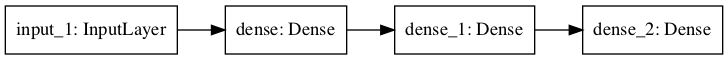

In [6]:
# Setting up the model -- fairly shallow net
tf.random.set_seed(7)
np.random.seed(7)

hidden_layers = 2
neurons_per_layer = 25
n_classes = 1
n_epoch = 100
val_fraction = 0.3
img_size = x_train.shape[1:]

model = tf.keras.models.Sequential([
    InputLayer(input_shape=img_size)    
])

for i in range(hidden_layers):
    model.add(Dense(neurons_per_layer, activation='elu', kernel_initializer='he_uniform'))

model.add(Dense(n_classes, activation='sigmoid'))
plot_model(model,rankdir='LR')

In [7]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# mc_adam = tf.keras.callbacks.ModelCheckpoint('best_model_adam.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
adam = tf.keras.optimizers.Adam(learning_rate=3.33e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])

history = model.fit(x_train,y_train,epochs=n_epoch,validation_split=val_fraction,callbacks=[es])

Train on 148 samples, validate on 64 samples
Epoch 1/100
148/148 [==============================] - 1s 7ms/sample - loss: 1.0279 - binary_accuracy: 0.4257 - val_loss: 0.8201 - val_binary_accuracy: 0.5312
Epoch 2/100
148/148 [==============================] - 0s 198us/sample - loss: 0.9732 - binary_accuracy: 0.4392 - val_loss: 0.7836 - val_binary_accuracy: 0.5312
Epoch 3/100
148/148 [==============================] - 0s 214us/sample - loss: 0.9231 - binary_accuracy: 0.4392 - val_loss: 0.7515 - val_binary_accuracy: 0.5312
Epoch 4/100
148/148 [==============================] - 0s 205us/sample - loss: 0.8775 - binary_accuracy: 0.4392 - val_loss: 0.7231 - val_binary_accuracy: 0.5469
Epoch 5/100
148/148 [==============================] - 0s 214us/sample - loss: 0.8381 - binary_accuracy: 0.4392 - val_loss: 0.6982 - val_binary_accuracy: 0.5469
Epoch 6/100
148/148 [==============================] - 0s 214us/sample - loss: 0.8011 - binary_accuracy: 0.4324 - val_loss: 0.6771 - val_binary_accuracy

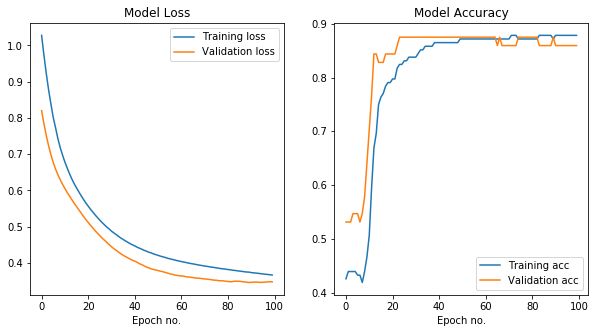

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss','Validation loss'])
plt.xlabel('Epoch no.')
plt.title('Model Loss')

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['Training acc','Validation acc'])
plt.xlabel('Epoch no.')
plt.title('Model Accuracy')
plt.show()

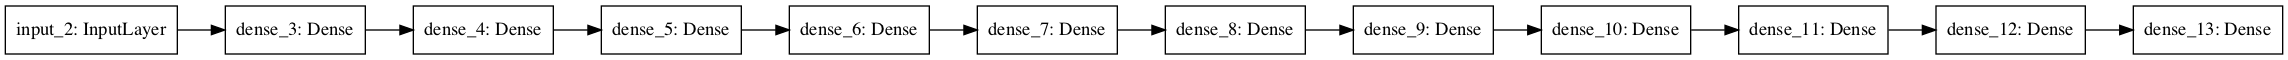

In [9]:
# Setting up the model -- deeper net
tf.random.set_seed(7)
np.random.seed(7)

hidden_layers = 10
neurons_per_layer = 25
n_classes = 1
n_epoch = 100
val_fraction = 0.3
img_size = x_train.shape[1:]

model = tf.keras.models.Sequential([
    InputLayer(input_shape=img_size)    
])

for i in range(hidden_layers):
    model.add(Dense(neurons_per_layer, activation='elu', kernel_initializer='he_uniform'))

model.add(Dense(n_classes, activation='sigmoid'))
plot_model(model,rankdir='LR')

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# mc_adam = tf.keras.callbacks.ModelCheckpoint('best_model_adam.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
adam = tf.keras.optimizers.Adam(learning_rate=3.33e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])

history_deep = model.fit(x_train,y_train,epochs=n_epoch,validation_split=val_fraction,callbacks=[es])

Train on 148 samples, validate on 64 samples
Epoch 1/100
148/148 [==============================] - 1s 9ms/sample - loss: 0.6735 - binary_accuracy: 0.6216 - val_loss: 0.5502 - val_binary_accuracy: 0.7344
Epoch 2/100
148/148 [==============================] - 0s 233us/sample - loss: 0.6054 - binary_accuracy: 0.6486 - val_loss: 0.5098 - val_binary_accuracy: 0.7812
Epoch 3/100
148/148 [==============================] - 0s 293us/sample - loss: 0.5562 - binary_accuracy: 0.6689 - val_loss: 0.4866 - val_binary_accuracy: 0.7812
Epoch 4/100
148/148 [==============================] - 0s 305us/sample - loss: 0.5202 - binary_accuracy: 0.7297 - val_loss: 0.4610 - val_binary_accuracy: 0.8594
Epoch 5/100
148/148 [==============================] - 0s 301us/sample - loss: 0.4908 - binary_accuracy: 0.7500 - val_loss: 0.4435 - val_binary_accuracy: 0.8594
Epoch 6/100
148/148 [==============================] - 0s 332us/sample - loss: 0.4711 - binary_accuracy: 0.7770 - val_loss: 0.4270 - val_binary_accuracy

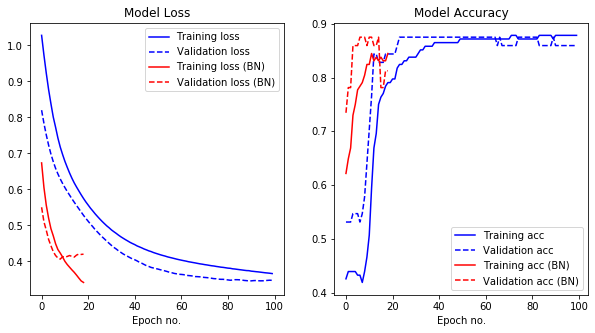

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],linestyle='-',color='b')
plt.plot(history.history['val_loss'],linestyle='--',color='b')
plt.plot(history_deep.history['loss'],linestyle='-',color='r')
plt.plot(history_deep.history['val_loss'],linestyle='--',color='r')
plt.legend(['Training loss','Validation loss','Training loss (BN)','Validation loss (BN)'])
plt.xlabel('Epoch no.')
plt.title('Model Loss')

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'],linestyle='-',color='b')
plt.plot(history.history['val_binary_accuracy'],linestyle='--',color='b')
plt.plot(history_deep.history['binary_accuracy'],linestyle='-',color='r')
plt.plot(history_deep.history['val_binary_accuracy'],linestyle='--',color='r')
plt.legend(['Training acc','Validation acc','Training acc (BN)','Validation acc (BN)'])
plt.xlabel('Epoch no.')
plt.title('Model Accuracy')
plt.show()

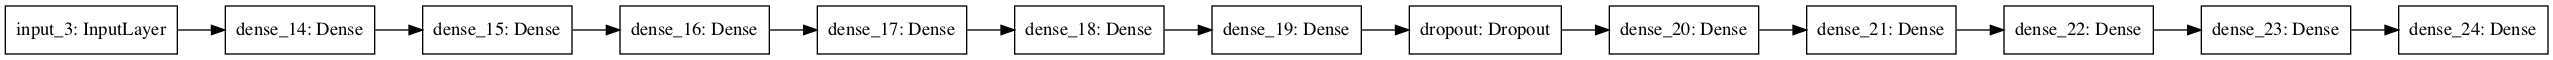

In [12]:
# Setting up the model -- fairly shallow net, with dropout
tf.random.set_seed(7)
np.random.seed(7)

hidden_layers = 10
neurons_per_layer = 25
dropout_fraction = 0.04
n_classes = 1
n_epoch = 100
val_fraction = 0.3
img_size = x_train.shape[1:]

model = tf.keras.models.Sequential([
    InputLayer(input_shape=img_size)    
])

for i in range(hidden_layers):
    model.add(Dense(neurons_per_layer, activation='elu', kernel_initializer='he_uniform'))
    if i==5:
        model.add(Dropout(dropout_fraction))

model.add(Dense(n_classes, activation='sigmoid'))
plot_model(model,rankdir='LR')

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# mc_adam = tf.keras.callbacks.ModelCheckpoint('best_model_adam.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
adam = tf.keras.optimizers.Adam(learning_rate=3.33e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])

history_do = model.fit(x_train,y_train,epochs=n_epoch,validation_split=val_fraction,callbacks=[es])

Train on 148 samples, validate on 64 samples
Epoch 1/100
148/148 [==============================] - 2s 11ms/sample - loss: 0.6745 - binary_accuracy: 0.6149 - val_loss: 0.5542 - val_binary_accuracy: 0.7188
Epoch 2/100
148/148 [==============================] - 0s 291us/sample - loss: 0.6150 - binary_accuracy: 0.6419 - val_loss: 0.5152 - val_binary_accuracy: 0.7656
Epoch 3/100
148/148 [==============================] - 0s 293us/sample - loss: 0.5706 - binary_accuracy: 0.6892 - val_loss: 0.4929 - val_binary_accuracy: 0.7969
Epoch 4/100
148/148 [==============================] - 0s 305us/sample - loss: 0.5176 - binary_accuracy: 0.7365 - val_loss: 0.4654 - val_binary_accuracy: 0.8594
Epoch 5/100
148/148 [==============================] - 0s 290us/sample - loss: 0.5178 - binary_accuracy: 0.7297 - val_loss: 0.4463 - val_binary_accuracy: 0.8750
Epoch 6/100
148/148 [==============================] - 0s 269us/sample - loss: 0.4833 - binary_accuracy: 0.7500 - val_loss: 0.4264 - val_binary_accurac

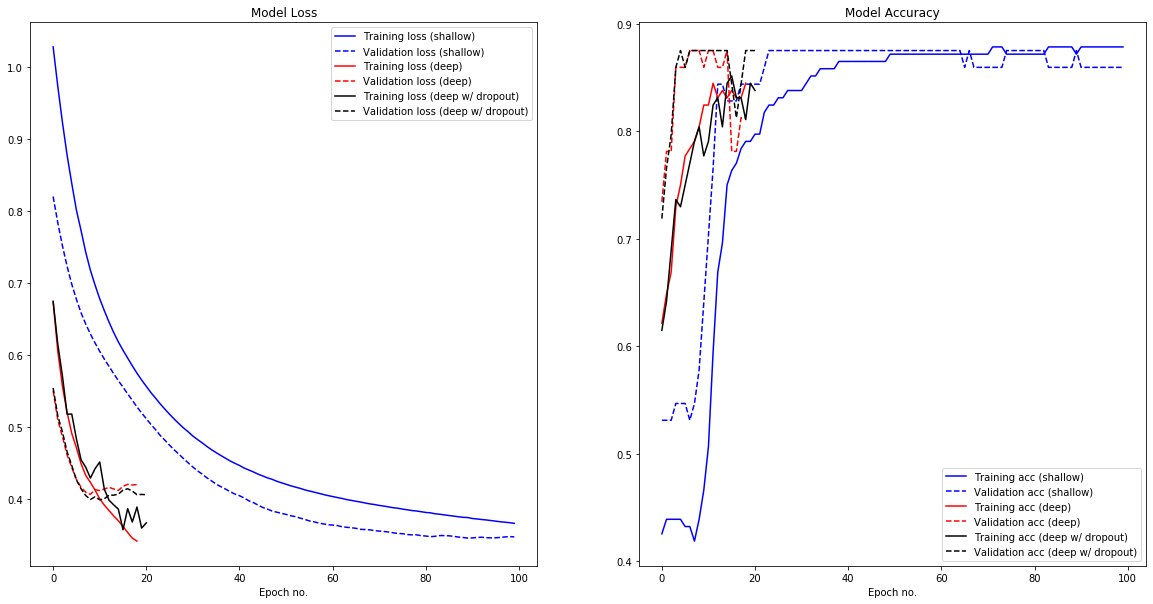

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],linestyle='-',color='b')
plt.plot(history.history['val_loss'],linestyle='--',color='b')
plt.plot(history_deep.history['loss'],linestyle='-',color='r')
plt.plot(history_deep.history['val_loss'],linestyle='--',color='r')
plt.plot(history_do.history['loss'],linestyle='-',color='k')
plt.plot(history_do.history['val_loss'],linestyle='--',color='k')
plt.legend(['Training loss (shallow)','Validation loss (shallow)','Training loss (deep)','Validation loss (deep)',
            'Training loss (deep w/ dropout)','Validation loss (deep w/ dropout)'])
plt.xlabel('Epoch no.')
plt.title('Model Loss')

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'],linestyle='-',color='b')
plt.plot(history.history['val_binary_accuracy'],linestyle='--',color='b')
plt.plot(history_deep.history['binary_accuracy'],linestyle='-',color='r')
plt.plot(history_deep.history['val_binary_accuracy'],linestyle='--',color='r')
plt.plot(history_do.history['binary_accuracy'],linestyle='-',color='k')
plt.plot(history_do.history['val_binary_accuracy'],linestyle='--',color='k')
plt.legend(['Training acc (shallow)','Validation acc (shallow)','Training acc (deep)','Validation acc (deep)',
            'Training acc (deep w/ dropout)','Validation acc (deep w/ dropout)'])
plt.xlabel('Epoch no.')
plt.title('Model Accuracy')
plt.show()